# Predicting 1994 Census Income

#### Keiti Lo

## Introduction
This data set includes data from the 1994 census summary data. I will be predicting whether income is above or below $50,000.

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.naive_bayes import CategoricalNB

## Reading and Preprocessing Data

### Read the Data

In [169]:
input_file = "https://raw.githubusercontent.com/grbruns/cst383/master/1994-census-summary.csv"
df = pd.read_csv(input_file)

### Preprocessing

In [170]:
# column usid
#
df.drop('usid', axis=1, inplace=True)

# column fnlwgt
#
df.drop('fnlwgt', axis=1, inplace=True)

## Data Exploration and Visualization

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   education       32561 non-null  object
 3   education_num   32561 non-null  int64 
 4   marital_status  32561 non-null  object
 5   occupation      30718 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital_gain    32561 non-null  int64 
 10  capital_loss    32561 non-null  int64 
 11  hours_per_week  32561 non-null  int64 
 12  native_country  31978 non-null  object
 13  label           32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [172]:
df.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


Classification of variables as categorical or numerical based on their types.

In [173]:
num_vars = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
cat_vars = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

I want to take a look at the distribution of values for these columns, especially looking at capital_gain and capital_loss. It seems odd to me that both of those columns are 0 for 25%, 50% and 75% marks, but have such a high number for their max. The 99999.00 looks especially unusual.

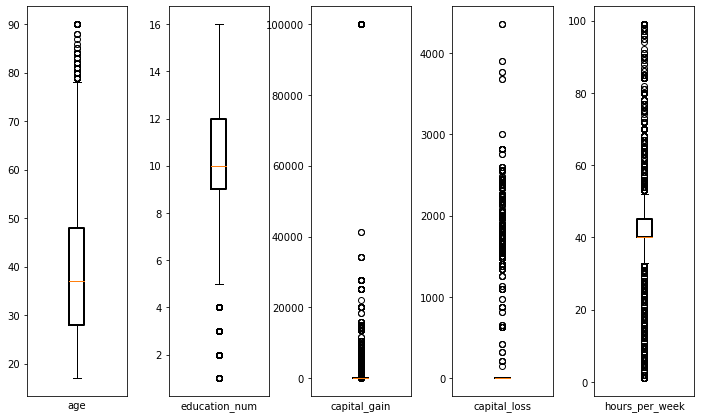

In [174]:
fig,axs = plt.subplots(1, len(num_vars), figsize=(10,6))
fig.tight_layout()
for i,x in enumerate(num_vars):
    axs[i].boxplot(df[x].values, boxprops={'linewidth':2})
    axs[i].set_xlabel(x)
    axs[i].set_xticks([])

Using box plots, I can easily identify outliers within the data. The box plot for capital_gain shows a distinct outlier at 99999. In order to decide how to deal with the outliers, I first want to see how many rows have a capital_gain of > 50000

In [175]:
len(df.loc[df['capital_gain'] > 50000])

159

Although 159 is only 0.005% of the entire data set, it's still a relatively large number of data to just drop. Instead, I will impute those rows with the median value.

In [176]:
df['capital_gain'].replace(99999, df['capital_gain'].median(), inplace=True)

Now I want to look at the numeric variables and how they relate to income. First I want to plot a histogram for each numeric variable so I can compare it with the density plots to understand it better.

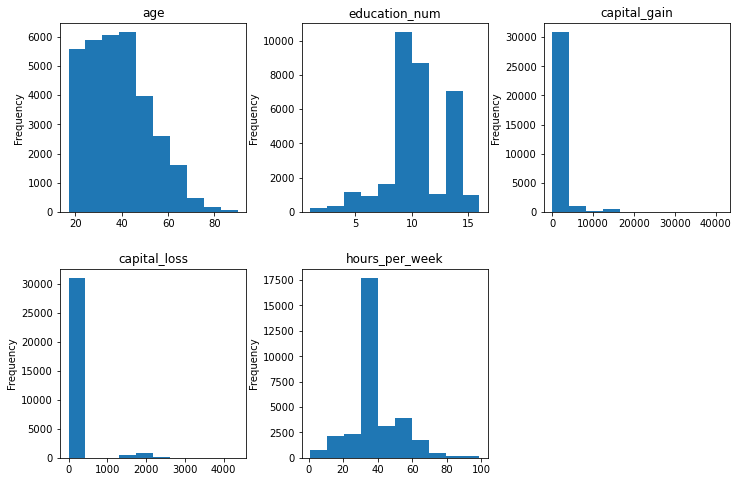

In [177]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(1, len(num_vars)+1):
    plt.subplot(2, 3, i)
    var = num_vars[i-1]
    df[var].plot.hist()
    plt.title(var);

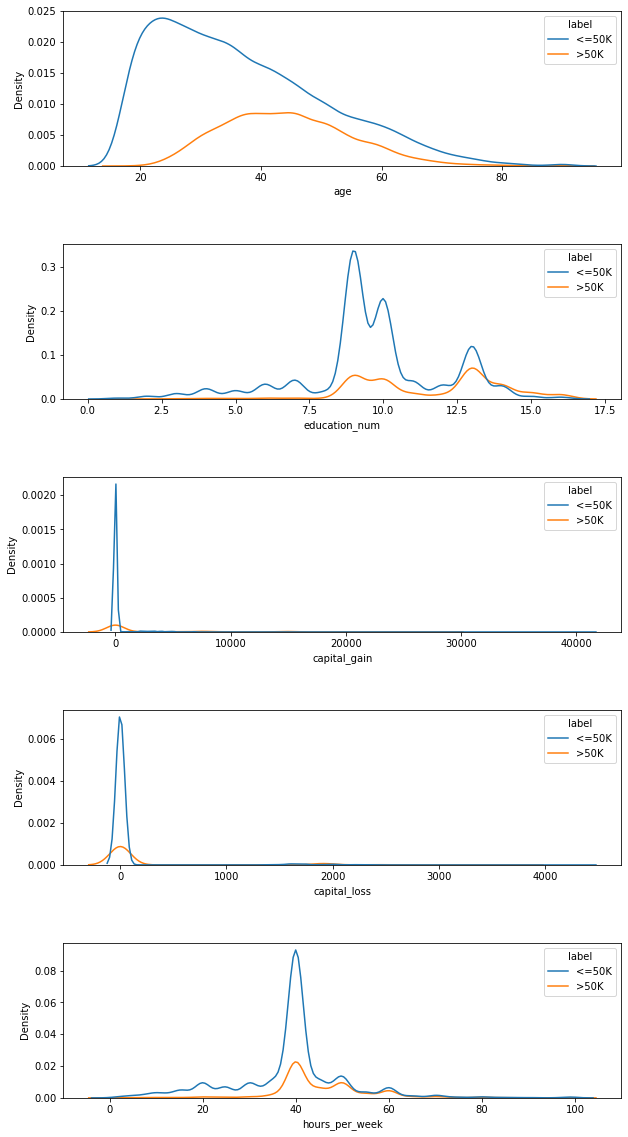

In [178]:
fig, ax = plt.subplots(len(num_vars),1, figsize=(10,20))
plt.subplots_adjust(hspace=0.5)
for i,x in enumerate(num_vars):
    sns.kdeplot(x=x, hue='label', data=df, ax=ax[i]);

It looks like capital_gain, capital_loss, and hours_per_week follow the histogram, but if you look at the age density plot, it is obvious that there is an increase in people who have an income >50K around the ages 38-43. You can also see a slightly higher number of income over 50K for those with education_num >14.

Now I want to take a look at the categorical variables and how the values in each one are distributed based on label.

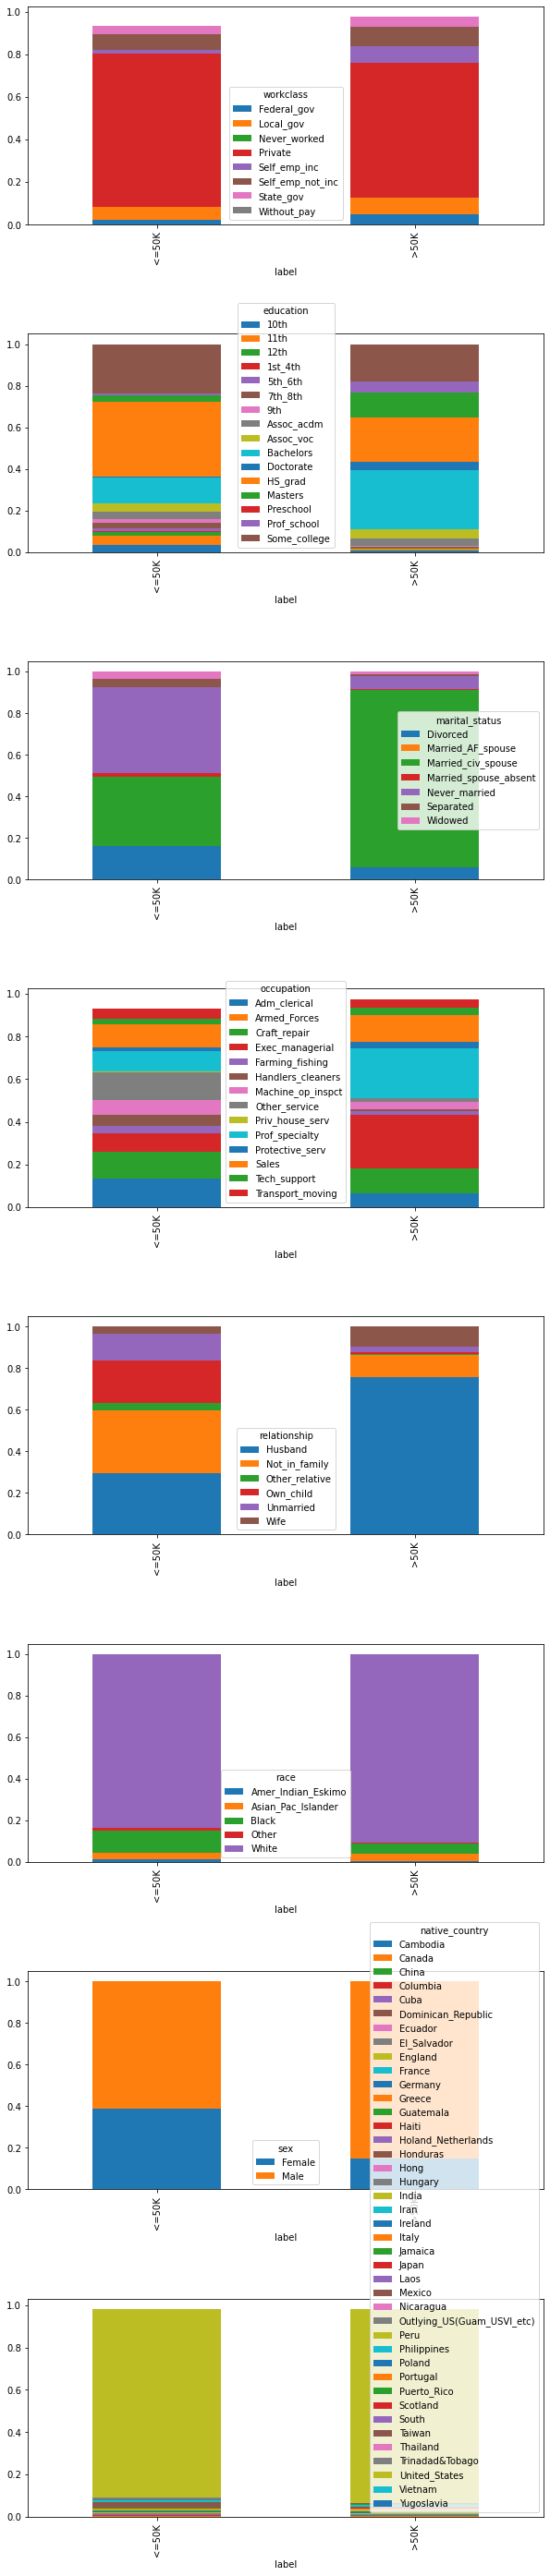

In [179]:
fig, ax = plt.subplots(len(cat_vars),1, figsize=(10,50))
plt.subplots_adjust(hspace=0.5)
for i,x in enumerate(cat_vars):
    a = pd.crosstab(df['label'],df[x])
    a = a.div(df['label'].value_counts(), axis=0)
    a.plot.bar(stacked=True, ax=ax[i]);

It looks like the distribution of the values in workclass is about the same for both >50K and <=50K. For education, you can see that there is a bigger range of values for those whose income is <= 50K. If their education was 11th, there is a greater chance in having <=50K, whereas if their education was Bachelor's it would be more likely to be >50K. For marital_status, a majority of those who earned >50K are Married_civ_spouse, whereas Never_married and Divorced are much more likely to have <=50K. Females are more likely to earn <=50K, those who are Husbands tend to have an income of >50K, and those whose occupation is either Prof_specialty or Transport_moving have a higher likelihood of earning >50K.

## Categorical Naive Bayes classifier

### Prepare Data

In [212]:
df['age_binned'] = pd.cut(df['age'], bins=np.arange(df['age'].min(), df['age'].max()+1, 5).tolist(), labels=False)
df['edu_binned'] = pd.cut(df['education_num'], bins=np.arange(df['education_num'].min(), df['education_num'].max()+1, 2).tolist(), labels=False)

from sklearn.preprocessing import LabelEncoder
df['sex'] = LabelEncoder().fit_transform(df['sex']).astype('float')
df['relationship'] = LabelEncoder().fit_transform(df['relationship']).astype('float')
df['marital_status'] = LabelEncoder().fit_transform(df['marital_status']).astype('float')
df['education'] = LabelEncoder().fit_transform(df['education']).astype('float')
df['label'] = LabelEncoder().fit_transform(df['label']).astype('float')

### Test/Train Split

In [213]:
# predictors = ['sex', 'relationship', 'marital_status', 'education', 'age_binned', 'edu_binned']
X = df[['sex', 'relationship','marital_status', 'education']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Prior Probabilities

In [189]:
probGreater = len(df.loc[df['label'] == 1])/len(df['label']) # >50K
probLess = len(df.loc[df['label'] == 0])/len(df['label']) # <=50K

### Training and Predictions

In [196]:
clf = CategoricalNB(class_prior=[probLess, probGreater])

clf.fit(X_train, y_train)

blind_prediction = np.median(y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

print("Baseline accuracy: {:.2f}".format((y_test == blind_prediction).mean()))
print("Test accuracy: {:.2f}".format(clf.score(X_test, y_test)))
pd.crosstab(y_test, columns=y_pred, colnames=['Predicted'], rownames=['Actual'])

Baseline accuracy: 0.76
Test accuracy: 0.76


Predicted,0,1
Actual,,
0,5583,1824
1,558,1804


Considering that my test accuracy is the same as the baseline accuracy, my model could really use some fine tuning. Using the learning curve, I will determine how to change my model to improve my test accuracy.

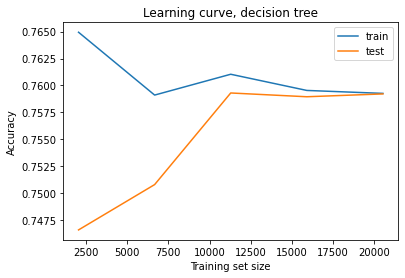

In [200]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning curve, decision tree')
plt.legend();

The training and test accuracy are extremely similar, indicating that I have a very high bias situation. In order to remedy this, it would be good to user more features as well as possibly deriving better features from the ones I already have. At this point, I feel stuck because I do not really understand Naive Bayes very well. I tried to bin my numeric variables so I could use it with my categorical variables with CategoricalNB, but I am getting nan errors when I add it to my predictors.

## Conclusion

This assignment was very disappointing because in class I thought I understood the concept of Naive Bayes, but when I started working on this mini-project, I realized I don't understand it enough to apply it to machine learning. I got stuck trying to bin my numeric variables and using them alongside my categorical variables. When I print the unique values of my binned variable, I get a bunch of numbers, but for some reason when I add it to my predictors, it reads them as NaNs.